In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt

# Load all result files
directory = Path('/home/bo/Project/MembershipAttribution/CascadedMA/output/EleutherAI/gpt-neo-125m/pile')
result_files = sorted(directory.glob('auc_step_*.json'), key=lambda p: int(p.stem.split('_')[-1]))

records = []
for file_path in result_files:
    step = int(file_path.stem.split('_')[-1])
    data = json.loads(file_path.read_text())
    for attack, auc in data.items():
        records.append({'step': step, 'attack': attack, 'auc': auc})

steps = sorted({r['step'] for r in records})
attack_order = ['loss', 'ref', 'min_k++', 'zlib', 'weighted_entropy']
attacks = [a for a in attack_order if any(r['attack'] == a for r in records)]

attack_to_auc = {attack: [] for attack in attacks}
for step in steps:
    for attack in attacks:
        val = next((r['auc'] for r in records if r['attack'] == attack and r['step'] == step), None)
        attack_to_auc[attack].append(val)


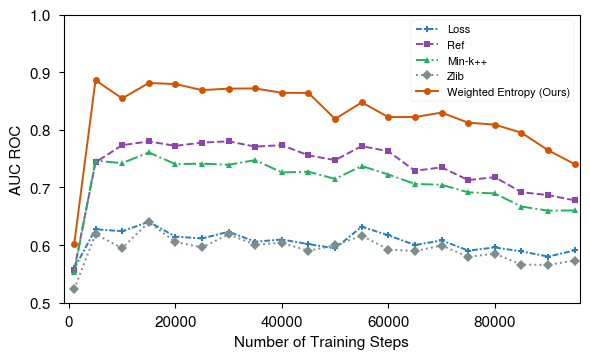

In [2]:

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'TeX Gyre Heros', 'DejaVu Sans']


colors = {
    'weighted_entropy': '#D35400', # 突出：南瓜橙 (温暖且显眼)
    'loss': '#2980B9',             # 冷色：蓝色
    'ref': '#8E44AD',              # 冷色：紫色
    'min_k++': '#27AE60',          # 冷色：绿色
    'zlib': '#7F8C8D',             # 中性：深灰
}

line_styles = {
    'loss':  (0, (3, 1, 1, 1)),
    'ref': '--',
    'min_k++': '-.',
    'zlib': ':',
    'weighted_entropy': '-',
}
markers = {
    'loss': 'P',
    'ref': 's',
    'min_k++': '^',
    'zlib': 'D',
    'weighted_entropy': 'o',
}
labels = {
    'loss': 'Loss',
    'ref': 'Ref',
    'weighted_entropy': 'Weighted Entropy (Ours)',
    'min_k++': 'Min-k++',
    'zlib': 'Zlib',
}
padding = max(steps) * 0.08
fig, ax = plt.subplots(figsize=(6, 3.7))
ax.tick_params(
    axis='both',       # 指定要应用设置的轴 ('x', 'y', 或 'both')
    labelsize=11,   # <--- 设置刻度标签（数字）的字体大小
)
for attack in attacks:
    ax.plot(
        steps,
        attack_to_auc[attack],
        marker=markers.get(attack, 'o'),
        # linewidth=2,
        markersize=5,
        linestyle=line_styles.get(attack, '-'),
        color=colors.get(attack, '#444'),
        # alpha=0.9,
        label=labels.get(attack, attack),
    )

ax.set_xlabel('Number of Training Steps', fontsize=11)
ax.set_ylabel('AUC ROC', fontsize=11)
ax.set_xlim(-1000, max(steps)+1000)
ax.set_ylim(0.5, 1.0)

leg = ax.legend(
    # loc='best',
    # bbox_to_anchor=(0.5, 1.15),
    ncol = 1,
    # markerfirst=False,
)
plt.savefig("key_observation_2.pdf", format="pdf", bbox_inches='tight')
plt.tight_layout()


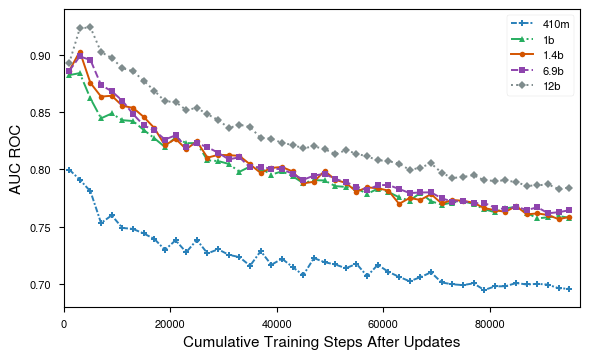

In [4]:
# Plot AUC ROC for pythia models across updating steps
ma_paths = [
    ('/home/bo/Project/MembershipAttribution/CascadedMA/output/pythia-410m-deduped/pile/ma_auc.json', '410m', 'loss'),
    ('/home/bo/Project/MembershipAttribution/CascadedMA/output/pythia-1b-deduped/pile/ma_auc.json', '1b', 'min_k++'),
    ('/home/bo/Project/MembershipAttribution/CascadedMA/output/pythia-1.4b-deduped/pile/ma_auc.json', '1.4b', 'weighted_entropy'),
    ('/home/bo/Project/MembershipAttribution/CascadedMA/output/pythia-6.9b-deduped/pile/ma_auc.json', '6.9b', 'ref'),
    ('/home/bo/Project/MembershipAttribution/CascadedMA/output/pythia-12b-deduped/pile/ma_auc.json', '12b', 'zlib'),
]

fig, ax = plt.subplots(figsize=(6, 3.7))
all_steps = []
for ma_path, label, color_key in ma_paths:
    ma_data = json.loads(Path(ma_path).read_text())
    ma_key, ma_record = next(iter(ma_data.items()))
    ma_steps = sorted(int(step) for step in ma_record)
    ma_auc = [ma_record[str(step)] for step in ma_steps]
    if label in ['6.9b', '1.4b']:
        ma_steps = ma_steps[::2]
        ma_auc = ma_auc[::2]

    all_steps.extend(ma_steps)
    ax.plot(
        ma_steps,
        ma_auc,
        marker=markers.get(color_key, 'o'),
        # linewidth=2,
        markersize=4,
        color=colors.get(color_key, '#2980B9'),
        linestyle=line_styles.get(color_key, '-'),
        label=f"{label}",
    )

ax.set_xlabel('Cumulative Training Steps After Updates', fontsize=11)
ax.set_ylabel('AUC ROC', fontsize=11)
ax.set_xlim(0, max(all_steps) + 2000)
ax.set_ylim([0.68, 0.94])
ax.set_yticks([0.7, 0.75, 0.8, 0.85, 0.9])
ax.legend()
plt.savefig('pythia-ma_auc.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
